In [ ]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,Dense,Conv1D,Flatten,LSTM,GlobalMaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
embed_num_dims = 100
max_seq_len = 1000

In [ ]:
data = pd.read_csv('jigsaw.csv',error_bad_lines=False)

In [ ]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
sentences = data['comment_text']

In [ ]:
sentences[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
dictt = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

Y = data[dictt].values

In [ ]:
tokenizer = Tokenizer(num_words = 4000)
tokenizer.fit_on_texts(sentences)
sequence = tokenizer.texts_to_sequences(sentences)

In [ ]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

210337


In [ ]:
padded_seq = pad_sequences(sequence , maxlen = max_seq_len )

In [ ]:
padded_seq

array([[   0,    0,    0, ..., 3085, 2273,  985],
       [   0,    0,    0, ...,  992,  589,  182],
       [   0,    0,    0, ...,    1,  737,  468],
       ...,
       [   0,    0,    0, ...,   23,   12, 3509],
       [   0,    0,    0, ...,  151,   34,   11],
       [   0,    0,    0, ..., 1627, 2056,   88]], dtype=int32)

In [ ]:
from keras.utils import to_categorical

#Y = to_categorical(Y)


In [ ]:

from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(padded_seq,Y ,train_size = 0.55)

In [ ]:
Y_train.shape

(87764, 6)

In [ ]:
f = open('glove.6B.100d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [ ]:
embedd_index['good']

array([-0.030769 ,  0.11993  ,  0.53909  , -0.43696  , -0.73937  ,
       -0.15345  ,  0.081126 , -0.38559  , -0.68797  , -0.41632  ,
       -0.13183  , -0.24922  ,  0.441    ,  0.085919 ,  0.20871  ,
       -0.063582 ,  0.062228 , -0.051234 , -0.13398  ,  1.1418   ,
        0.036526 ,  0.49029  , -0.24567  , -0.412    ,  0.12349  ,
        0.41336  , -0.48397  , -0.54243  , -0.27787  , -0.26015  ,
       -0.38485  ,  0.78656  ,  0.1023   , -0.20712  ,  0.40751  ,
        0.32026  , -0.51052  ,  0.48362  , -0.0099498, -0.38685  ,
        0.034975 , -0.167    ,  0.4237   , -0.54164  , -0.30323  ,
       -0.36983  ,  0.082836 , -0.52538  , -0.064531 , -1.398    ,
       -0.14873  , -0.35327  , -0.1118   ,  1.0912   ,  0.095864 ,
       -2.8129   ,  0.45238  ,  0.46213  ,  1.6012   , -0.20837  ,
       -0.27377  ,  0.71197  , -1.0754   , -0.046974 ,  0.67479  ,
       -0.065839 ,  0.75824  ,  0.39405  ,  0.15507  , -0.64719  ,
        0.32796  , -0.031748 ,  0.52899  , -0.43886  ,  0.6740

In [ ]:
embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)

In [ ]:
embedding_matrix.shape

(210338, 100)

(200, 2)


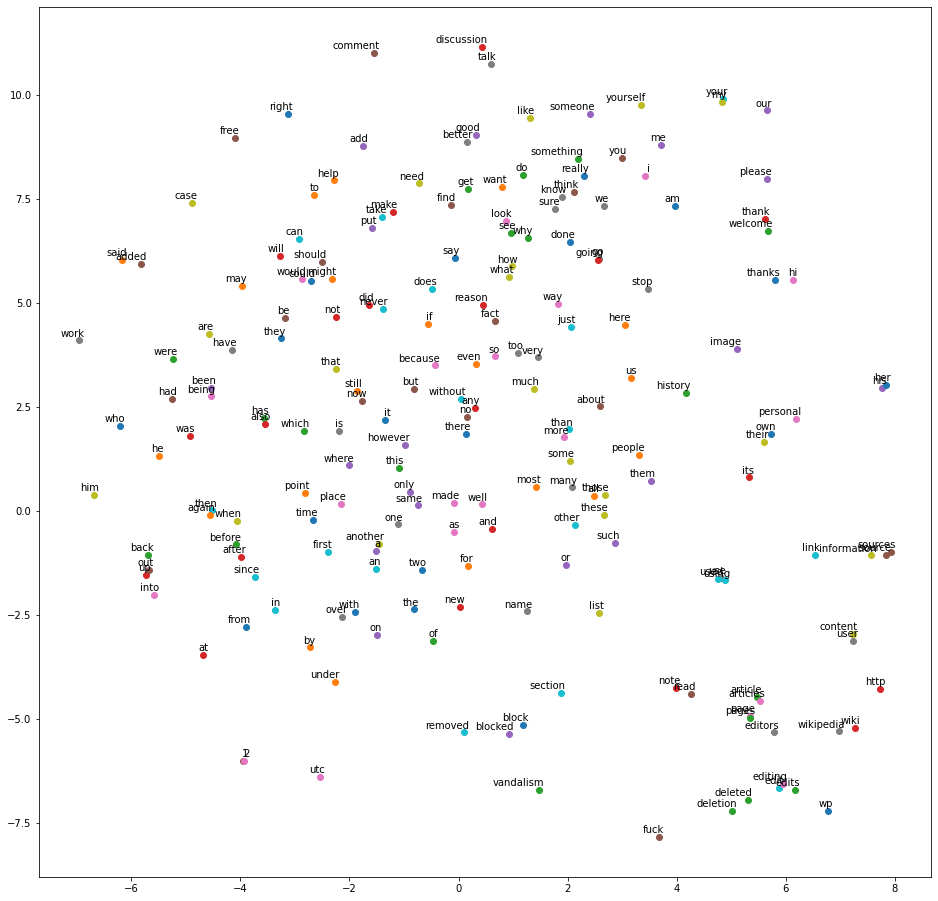

In [ ]:
#TSNE algorithm used to visualize word embeddings having huge amount (100) dimensions

def tsne():
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])
    print(new_values.shape)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    
    
    
    
tsne()
    

### OBSERVATIONS:

1.Numbers are clubbed together .
2.Words such as  murderous and injustice are postioned near each other . 
3.Many proper nouns are placed 
4.Hindi words such as 'rigveda','majdal','prakashan','palakkad' are placed together


In [ ]:
#Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(len(index_of_words) + 1 , embed_num_dims , input_length = max_seq_len , weights = [embedding_matrix])

In [ ]:
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(30 , return_sequences = True , dropout = 0.1 , recurrent_dropout = 0.1)))
model.add(GlobalMaxPooling1D())
model.add(Dense(30,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(6,activation = 'sigmoid'))

In [ ]:
model.summary()

NameError: ignored

In [ ]:
from keras.models import model_from_json
def load():
    load_json = open("weights.json",'r')
    loaded = load_json.read()
    load_json.close()
    load = model_from_json(loaded)
    load.load_weights("model.h5")
    print("Loaded")
    model = load

In [ ]:
from keras.optimizers import Adam
add = Adam(lr = 0.01)
model.compile(loss = 'categorical_crossentropy' , optimizer = add , metrics = ['accuracy'])

In [ ]:
hist = model.fit(X_train,Y_train,epochs = 1 , batch_size = 500, validation_data = (X_test,Y_test))

Train on 87764 samples, validate on 71807 samples
Epoch 1/1
87764/87764 [==============================] - 1269s 14ms/step - loss: 0.3059 - acc: 0.9942 - val_loss: 0.2969 - val_acc: 0.9941


In [ ]:
result = model.evaluate(X_test,Y_test)

71807/71807 [==============================] - 308s 4ms/step


In [ ]:
print(result[1]*100)

99.40952831772101


In [ ]:
def prepare_submission():
    test = pd.read_csv('test.csv')

    test_data = test['comment_text']
    test_id = test['id']

    tokenizer.fit_on_texts(test_data)
    sequence = tokenizer.texts_to_sequences(test_data)
    test_final = pad_sequences(sequence, maxlen = max_seq_len )
    result_final = model.predict(test_final)

    dataf = pd.DataFrame(data = {'id' : test_id , 'toxic' : result_final[:,0] ,'severe_toxic' : result_final[:,1] ,'obscene' : result_final[:,2] , 'threat' : result_final[:,3]  , 'insult' : result_final[:,4] , 'identity_hate' : result_final[:,5]  })
    dataf.to_csv('result_jigsaw.csv')

In [ ]:
prepare_submission()